In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
import random

In [2]:
VOCAB_SIZE = 40000
MAX_LEN = 512
BATCH_SIZE = 8
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_HEADS = 16
NUM_LAYERS = 5
DROPOUT = 0.1
EPOCHS = 20
OUTPUT_SIZE = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = 'personality.csv'

In [3]:
def lower(inp):
    return str(inp).lower()


# Train sentencepiece tokenizer
def train_tokenizer(data_file, model_prefix, vocab_size=VOCAB_SIZE):
    df = pd.read_csv(data_file)
    text_data = df.iloc[:, 1].apply(lower).tolist()

    with open("text_corpus_1.txt", "w", encoding="utf-8") as f:
        for line in text_data:
            f.write(line + "\n")

    spm.SentencePieceTrainer.Train(
        input="text_corpus_1.txt",
        model_prefix=model_prefix,
        vocab_size=vocab_size,
    )

# Uncomment if train needed
# train_tokenizer(DATASET, "tokenizer1")

In [4]:
# Load tokenizer
tokenizer = spm.SentencePieceProcessor(model_file="tokenizer1.model")

def encode_text(sentence, tokenizer, max_len=50):
    tokens = tokenizer.encode(sentence, out_type=int)
    tokens = [1] + tokens[:max_len-2] + [2]  # BOS = 1, EOS = 2
    return tokens + [0] * (max_len - len(tokens))


tokenizer_func = lambda text: encode_text(text, tokenizer, MAX_LEN)

print(tokenizer.encode("привет. как дела?",))

[198, 3, 23, 1278, 3276, 15, 21, 376, 9]


In [5]:
# Dataset class
class TranslationDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.text = df.iloc[:, 1].apply(lower).tolist()
        df = df.iloc[:, 2:]

        # Convert columns O1...O6, ..., N1...N6 into O, ..., N
        self.data = pd.DataFrame()
        for trait in 'OCEAN':
            scores = df[[f'{trait}{x}' for x in range(1, 7)]].sum(axis=1)
            self.data[trait] = scores

        # Apply z-score normalization
        self.data = (self.data - self.data.mean()) / self.data.std()
        
        print(self.data[::10000])

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        data = self.data.loc[[idx]].astype(float).values.flatten().tolist()
        src_tokens = torch.tensor(tokenizer_func(text), dtype=torch.long), torch.tensor(data)
        return src_tokens


In [6]:
# Create dataloader
train_dataset = TranslationDataset(DATASET)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


                O         C         E         A         N
0        0.371170  0.055268 -0.364486 -0.489272 -2.330357
10000   -0.237508  1.186232  0.693082  0.633002 -0.652676
20000   -0.034615 -0.809587  0.995244 -1.910819  0.046358
30000    1.689975 -0.743060 -1.119892  1.381185 -0.233255
40000   -1.353420 -0.743060 -0.137864 -0.489272  0.745392
...           ...       ...       ...       ...       ...
1090000  2.095761  1.784978  0.617541  1.306367 -3.169198
1100000  0.269724 -0.476951 -1.195432 -1.087818  0.325972
1110000  0.269724 -0.476951 -1.195432 -1.087818  0.325972
1120000  0.675510  0.454432  2.808218 -0.040362  0.745392
1130000 -0.034615  1.053177 -0.137864  1.081912 -0.862386

[114 rows x 5 columns]


In [7]:
train_dataset.__getitem__(3900)

(tensor([    1,     5,   839, 14276,  1884,   112,     7,  1357,    11,  1075,
          3953,     5,    10,   953,  8533,     7,     8,  7110,   112,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [8]:
import torch.nn as nn

In [9]:
class PersonalityAnalyzer(nn.Module):
    def __init__(
        self,
        vocab_size,  # Size of the vocabulary
        model_dim,  # Dimension of embeddings and hidden layers
        num_attention_heads,  # Number of attention heads in each Transformer layer
        num_encoder_layers,  # Number of stacked Transformer encoder layers
        feedforward_dim,  # Hidden layer size in the feedforward network
        max_sequence_length,  # Maximum input sequence length
        dropout_prob=0.2,  # Dropout probability
        output_size=5,  # Final output size (5 neurons by default)
    ):
        super().__init__()

        # Embedding layers for token and position encodings
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.position_embedding = nn.Embedding(max_sequence_length, model_dim)
        self.embedding_dropout = nn.Dropout(dropout_prob)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_attention_heads,
            dim_feedforward=feedforward_dim,
            dropout=dropout_prob,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        # Pooling layer to aggregate sequence output
        self.pooling = nn.AdaptiveAvgPool1d(1)  # Global average pooling over time dimension
        #self.pooling_dropout = nn.Dropout(0.2)

        # Final fully connected layer with N output neurons
        self.fc_out = nn.Linear(model_dim, output_size)

    def forward(self, input_tokens):
        batch_size, seq_len = input_tokens.shape

        # Create position indices and embed them
        positions = torch.arange(seq_len, device=input_tokens.device).unsqueeze(0).expand(batch_size, seq_len)
        token_embeddings = self.token_embedding(input_tokens)
        position_embeddings = self.position_embedding(positions)

        # Add embeddings and apply dropout
        x = self.embedding_dropout(token_embeddings + position_embeddings)

        # Pass through Transformer encoder
        encoded_output = self.encoder(x)

        # Pooling across sequence length to get a single vector per sample
        pooled_output = self.pooling(encoded_output.permute(0, 2, 1)).squeeze(-1)
        #pooled_output = self.pooling_dropout(pooled_output)

        # Final projection to N neurons
        output = self.fc_out(pooled_output)

        return output

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PersonalityAnalyzer(
    VOCAB_SIZE,
    EMBED_SIZE,
    NUM_HEADS,
    NUM_LAYERS,
    HIDDEN_SIZE,
    MAX_LEN,
    DROPOUT,
    OUTPUT_SIZE,
).to(device)
model

PersonalityAnalyzer(
  (token_embedding): Embedding(40000, 512)
  (position_embedding): Embedding(512, 512)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-4): 5 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc_out): Linear(in_features=512, out_features=5, bias=True)
)

In [11]:
# Initialize weights for model
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

model.apply(init_weights)

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(0.)

In [12]:
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

# Different loss strategies have been tested
#criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()
criterion = nn.L1Loss()

In [13]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

28,634,629 total parameters.
28,634,629 training parameters.



In [19]:
def calculate_traits_for_text(text):
    with torch.no_grad():
        score = model(torch.tensor(tokenizer_func(text)).unsqueeze(0).to(device))
    return score.cpu().detach().numpy()[0]

# Predict output for test samples and display
def test_model(model, samples=None):
    model.eval()

    cols = [
        "Открытость опыту",
        "Рассудительность",
        "Экстраверсия",
        "Доброжелательность",
        "Нейротизм",
    ]
    ans = pd.DataFrame(cols)

    if samples is None:
        samples = ['😂', '🥺', '❤️', 'всем привет', 'всем привет!', 'всем привет)', 'мне плохо(']
    
    for sample in samples:
        traits = calculate_traits_for_text(sample)
        ans[sample] = pd.Series(traits)

    display(ans)

## Training

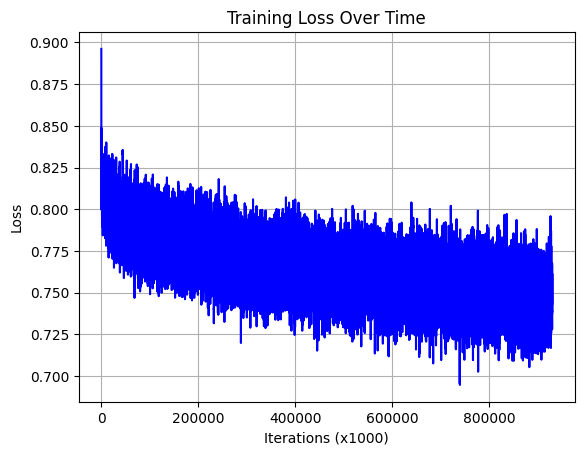

Epoch [7/20]
E [54.3%] 77232/142128
T [32.7%] 930000/2842560
Mean loss: 0.7128288179636002


,0,😂,🥺,❤️,всем привет,всем привет!,всем привет),мне плохо(
0,Открытость опыту,0.076167,0.016302,0.009877,-0.090604,0.169953,-0.193214,-0.021502
1,Рассудительность,0.349388,-0.114274,0.022920,-0.105014,0.042750,0.568607,-0.108108
2,Экстраверсия,0.401684,-0.097621,0.007413,0.001174,0.329990,0.064488,-0.016207
3,Доброжелательность,0.350798,0.247285,0.040794,0.033423,0.281041,0.469442,-0.007527
4,Нейротизм,-0.365002,0.227167,-0.150224,-0.032008,-0.188353,-0.999937,0.048228


In [15]:
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import numpy

def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def train(model, dataloader, optimizer, criterion, device, num_epochs=5, update_freq=100, scheduler=None):
    model.train()
    model.to(device)

    loss_history = []  # Store loss values for plotting
    step_losses = []  # Track loss for every update_freq iterations
    global_step = 0

    for epoch in range(num_epochs):
        total_loss = 0
        epochs = num_epochs
        local_step = 0

        for i, (text, traits) in enumerate(dataloader):
            optimizer.zero_grad()
            inputs = text.to(device)
            targets = traits.to(device).float()

            logits = model(inputs)
            loss = criterion(logits, targets)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            step_losses.append(loss.item())
            global_step += 1
            local_step += 1

            # 🔥 Update graph every `update_freq` iterations
            if global_step % update_freq == 0:
                avg_loss = total_loss / len(dataloader)
                clear_output(wait=True)

                # Plot loss graph
                plt.plot(running_mean(step_losses, 100),
                         linestyle='-',
                         color='b')
                plt.xlabel(f"Iterations (x{update_freq})")
                plt.ylabel("Loss")
                plt.title("Training Loss Over Time")
                plt.grid()
                plt.show()

                print(f"Epoch [{epoch+1}/{epochs}]")
                ls = local_step
                ldl = len(dataloader)
                print(f"E [{round(ls/ldl*100,1)}%] {ls}/{ldl}")
                print(f"T [{round(global_step/(ldl*epochs)*100,1)}%] {global_step}/{ldl*epochs}")
                last_10_loss = step_losses[-30:]
                print(f"Mean loss: {sum(last_10_loss)/30}")
                test_model(model)
                model.train()
    
        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


# Train model
train(model, train_loader, optimizer, criterion, device, num_epochs=EPOCHS, update_freq=1000, scheduler=scheduler)

## Usage

In [20]:
calculate_traits_for_text('всем привет! как у вас дела?')

array([ 0.07777058,  0.23663813,  0.19246727,  0.39932284, -0.2505312 ],
      dtype=float32)

## Save/load model

In [21]:
# Saving the model
def save_model(model, optimizer, scheduler, filepath, only_model=False):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, filepath + '.pth')
    print(f"Model saved to {filepath}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, filepath + '_for_training.pth')
    print(f"Model saved to {filepath}_for_training.pth")

# Loading the model
def load_model(model, optimizer, scheduler, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print(f"Model loaded from {filepath}")

def load_model_only(model, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded from {filepath}")

In [22]:
save_model(model, optimizer, scheduler, 'personality_5')

Model saved to personality_5.pth
Model saved to personality_5_for_training.pth


In [23]:
# load_model_only(model, 'model/personality_5.pth')